# Let's build all kind of auto-cma models.

In this notebook we will do automated algorithm configuration on the CMA data. Using the best performing configurations per instance for all BBOB functions and their ELA features.

In [1]:
#imports
import os
import pandas as pd
import re
import numpy as np
from tqdm import tqdm
from ioh_xplainer import explainer
import pandas as pd
import ioh
from scipy.stats import qmc
from ConfigSpace import ConfigurationSpace
from ConfigSpace.util import generate_grid
from IPython.display import display
from time import monotonic
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from matplotlib import pyplot as plt
import seaborn as sns

/home/bas/repos/ioh-explainer/env/lib/python3.8/site-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/bas/repos/ioh-explainer/env/lib/python3.8/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/home/bas/repos/ioh-explainer/env/lib/python3.8/site-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/bas/repos/ioh-explainer/env/lib/python3.8/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
IProgress not found. Please update jupyter and ipywidgets. See

In [7]:
ela_df = pd.read_pickle("ela-features-cma.pkl")
features = ['covariance','elitist', 'mirrored', 'base_sampler', 'weights_option', 'local_restart', 'step_size_adaptation', 'lambda_', 'mu']

ela_df[['dim','fid',*features, 'auc']].to_latex("cma-hall-of-fame.tex",index=False,)
ela_df[['dim','fid',*features, 'auc']]


,dim,fid,covariance,elitist,mirrored,base_sampler,weights_option,local_restart,step_size_adaptation,lambda_,mu,auc
0,5,1,True,True,mirrored,halton,default,BIPOP,csa,5.0,2.0,0.985746
1,5,1,True,True,mirrored,halton,1/2^lambda,BIPOP,csa,5.0,5.0,0.983376
2,5,1,True,True,mirrored pairwise,halton,1/2^lambda,BIPOP,csa,5.0,5.0,0.984011
3,5,1,True,True,mirrored,halton,1/2^lambda,BIPOP,csa,5.0,5.0,0.984186
4,5,1,True,True,mirrored,halton,1/2^lambda,BIPOP,csa,5.0,5.0,0.985330
...,...,...,...,...,...,...,...,...,...,...,...,...
235,30,24,True,False,mirrored,sobol,default,IPOP,csa,8.0,4.0,0.031490
236,30,24,False,False,mirrored,halton,equal,BIPOP,psr,20.0,5.0,0.029699
237,30,24,False,False,mirrored,halton,equal,BIPOP,csa,20.0,10.0,0.038790
238,30,24,False,False,mirrored,sobol,equal,IPOP,psr,20.0,5.0,0.029582


In [8]:
#load explainer
data_file = "cma_final.pkl" #read in modular DE data
df = pd.read_pickle(data_file)

config_dict = {}
for f in features:
    config_dict[f] = list(map(str, df[f].unique()))

config_dict['elitist'] = [False, True]
config_dict['active'] = [False, True]
config_dict['covariance'] = [False, True]

cs = ConfigurationSpace(config_dict)

print(cs)

cmaes_explainer = explainer(None, 
                 cs , 
                 algname="mod-CMA",
                 dims = [5,30],#, 10, 20, 40 
                 fids = np.arange(1,25), #,5
                 iids = df['iid'].unique(), #20 
                 reps = len( df['seed'].unique()), 
                 sampling_method = "grid",  #or random
                 grid_steps_dict = {},
                 sample_size = None,  #only used with random method
                 budget = 10000, #10000
                 seed = 1,
                 verbose = True)

cmaes_explainer.load_results(data_file)
cmaes_explainer.df.loc[cmaes_explainer.df["dim"] == 30,'auc'] = cmaes_explainer.df.loc[cmaes_explainer.df["dim"] == 30,'aucLarge']

Configuration space object:
  Hyperparameters:
    active, Type: Categorical, Choices: {False, True}, Default: False
    base_sampler, Type: Categorical, Choices: {sobol, gaussian, halton}, Default: sobol
    covariance, Type: Categorical, Choices: {False, True}, Default: False
    elitist, Type: Categorical, Choices: {False, True}, Default: False
    lambda_, Type: Categorical, Choices: {6.0, 8.0, 5.0, 10.0, 20.0}, Default: 6.0
    local_restart, Type: Categorical, Choices: {nan, IPOP, BIPOP}, Default: nan
    mirrored, Type: Categorical, Choices: {nan, mirrored, mirrored pairwise}, Default: nan
    mu, Type: Categorical, Choices: {3.0, 4.0, 5.0, 2.0, 10.0, 20.0}, Default: 3.0
    step_size_adaptation, Type: Categorical, Choices: {csa, psr}, Default: csa
    weights_option, Type: Categorical, Choices: {default, equal, 1/2^lambda}, Default: default



In [9]:
for f in features:
    print(f, ela_df[f].unique())

categorical_columns = features

df = ela_df.copy()
for cat in categorical_columns:
    print(cat)
    df[cat] = df[cat].astype('category')
    print(df[cat].unique())
    print(df[cat].cat.codes.unique())

ela_df_cat = ela_df.copy()
ela_df_cat[features] = ela_df_cat[features].apply(lambda col:pd.Categorical(col).codes)

covariance [ True False]
elitist [ True False]
mirrored ['mirrored' 'mirrored pairwise']
base_sampler ['halton' 'sobol' 'gaussian']
weights_option ['default' '1/2^lambda' 'equal']
local_restart ['BIPOP' 'IPOP']
step_size_adaptation ['csa' 'psr']
lambda_ [ 5. 20. 10.  6.  8.]
mu [ 2.  5. 10.  3. 20.  4.]
covariance
[True, False]
Categories (2, bool): [False, True]
[1 0]
elitist
[True, False]
Categories (2, bool): [False, True]
[1 0]
mirrored
['mirrored', 'mirrored pairwise']
Categories (2, object): ['mirrored', 'mirrored pairwise']
[0 1]
base_sampler
['halton', 'sobol', 'gaussian']
Categories (3, object): ['gaussian', 'halton', 'sobol']
[1 2 0]
weights_option
['default', '1/2^lambda', 'equal']
Categories (3, object): ['1/2^lambda', 'default', 'equal']
[1 0 2]
local_restart
['BIPOP', 'IPOP']
Categories (2, object): ['BIPOP', 'IPOP']
[0 1]
step_size_adaptation
['csa', 'psr']
Categories (2, object): ['csa', 'psr']
[0 1]
lambda_
[5.0, 20.0, 10.0, 6.0, 8.0]
Categories (5, float64): [5.0, 6.0

5 1
5 2
5 3
5 4
5 5
5 6
5 7
5 8
5 9
5 10
5 11
5 12
5 13
5 14
5 15
5 16
5 17
5 18
5 19
5 20
5 21
5 22
5 23
5 24
30 1
30 2
30 3
30 4
30 5
30 6
30 7
30 8
30 9
30 10
30 11
30 12
30 13
30 14
30 15
30 16
30 17
30 18
30 19
30 20
30 21
30 22
30 23
30 24


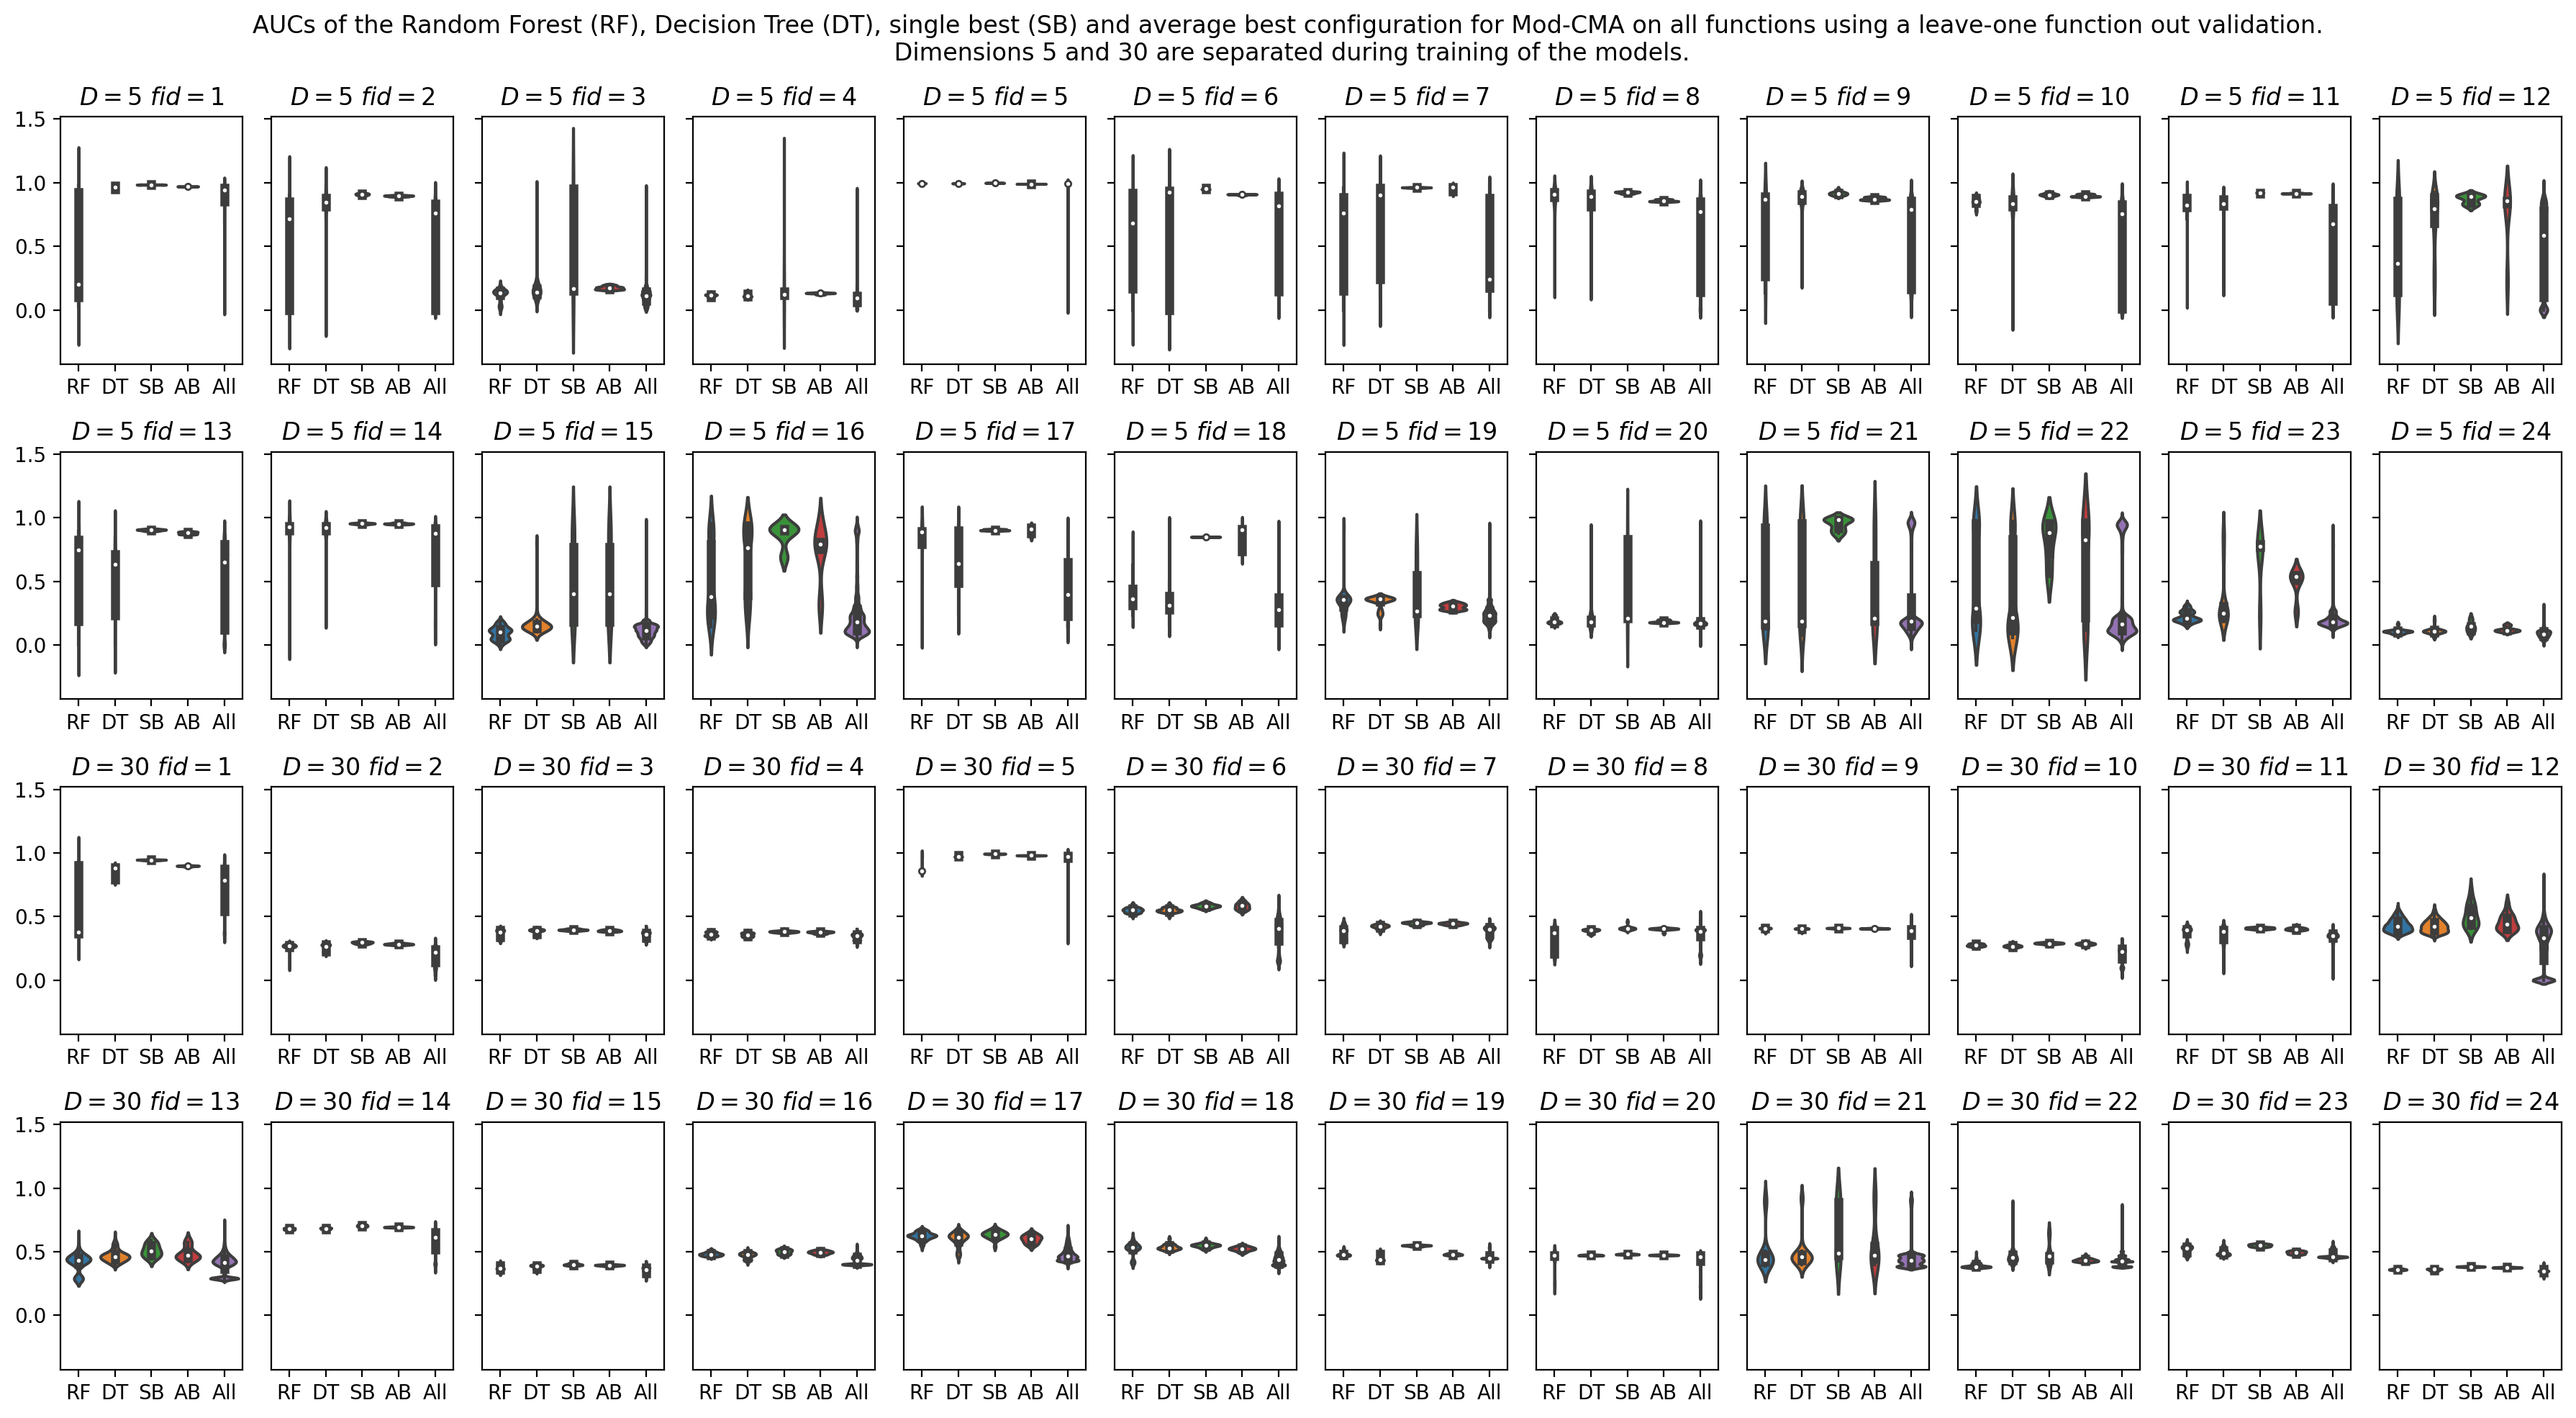

In [24]:

#leave one function out 
def predToNames(y, dim):
    #print(y)
    #['covariance','elitist', 'mirrored', 'base_sampler', 'weights_option', 'local_restart', 'step_size_adaptation', 'lambda_', 'mu']
    mapping = [[False, True],[False, True], ['mirrored', 'mirrored pairwise'], ['gaussian', 'halton', 'sobol'],['1/2^lambda', 'default', 'equal'], ['BIPOP', 'IPOP'], 
                ['csa', 'psr'], [5.0, 6.0, 8.0, 10.0, 20.0], [2.0, 3.0, 4.0, 5.0, 10.0, 20.0]]
    newy = {}
    i = 0
    for f in features:
        #print(f,i,y[i])
        newy[f] = mapping[i][y[i]]
        i+=1
    #transform a numerical representation back to the categorical names
    return newy



#preprocess the data to train and test
fig, axes = plt.subplots(4, 12, sharey=True, figsize=(18,10))
fig.suptitle('AUCs of the Random Forest (RF), Decision Tree (DT), single best (SB) and average best configuration for Mod-CMA on all functions using a leave-one function out validation.\n Dimensions 5 and 30 are separated during training of the models.')

dim_counter = 0
for dim in ela_df['dim'].unique():
    _, df_avg_best = cmaes_explainer.get_average_best(dim)
    
    for fid in ela_df['fid'].unique():
        print(dim, fid)
        box_plot_df = pd.DataFrame(columns=['RF', 'DT','SB','AB', 'All'])

        _, df_single_best = cmaes_explainer.get_single_best(fid, dim)
        box_plot_df['All'] = pd.Series(cmaes_explainer.df[(cmaes_explainer.df['fid'] == fid) & (cmaes_explainer.df['dim'] == dim)]['auc'].values)
        box_plot_df['SB'] = pd.Series(df_single_best['auc'].values)
        box_plot_df['AB'] = pd.Series(df_avg_best[df_avg_best['fid'] == fid]['auc'].values)
        

        df = ela_df_cat[ela_df_cat['dim'] == dim]
        
        X_train = df[df['fid'] != fid].copy().drop(['fid','iid','auc',*features], axis=1)
        y_train = df[df['fid'] != fid][features]
        X_test = df[df['fid'] == fid].copy().drop(['fid','iid','auc',*features], axis=1)
        y_test = df[df['fid'] == fid][features]

        X_train.replace([np.inf, -np.inf], 0, inplace=True)
        X_test.replace([np.inf, -np.inf], 0, inplace=True)
        X_train.fillna(0, inplace=True)
        X_test.fillna(0, inplace=True)

        #y_train[features] = y_train[features].apply(lambda col:pd.Categorical(col).codes)
        #y_test[features] = y_test[features].apply(lambda col:pd.Categorical(col).codes)
    
        dtree = DecisionTreeClassifier(max_depth=7)
        dtree.fit(X_train, y_train)
        y_pred = dtree.predict(X_test)

        #RF
        rf = RandomForestClassifier()
        rf.fit(X_train, y_train)
        y_red_rf = rf.predict(X_test)

        iid = 1
        all_aucs = []
        all_aucs_rf = []
        for y in y_pred:
            #print(y)
            conf = predToNames(y, dim)
            #print(conf)
            aucs = cmaes_explainer.get_results_for_config(conf, dim, fid)
            all_aucs.extend(aucs.values)
            #print(all_aucs)
        for y in y_red_rf:
            #print(y)
            conf = predToNames(y, dim)
            #print(conf)
            aucs = cmaes_explainer.get_results_for_config(conf, dim, fid)
            all_aucs_rf.extend(aucs.values)
            #print(all_aucs)

        box_plot_df['DT'] = pd.Series(np.array(all_aucs))
        box_plot_df['RF'] = pd.Series(np.array(all_aucs_rf))

        sns.violinplot(ax=axes[dim_counter + int((fid-1)/12)][(fid-1)%12], data=box_plot_df, showfliers = True, showmeans=True,
                    meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"6"})  
        axes[dim_counter + int((fid-1)/12)][(fid-1)%12].set_title(f"$D={dim}$ $fid={fid}$")
        #axes[dim_counter + int((fid-1)/12)][(fid-1)%12].set_xticklabels(axes[dim_counter + int((fid-1)/12)][(fid-1)%12].get_xticks(), rotation=45)
    dim_counter += 2

plt.tight_layout()
plt.savefig("cma_img_new/classifiers-fid.pdf")
plt.savefig("cma_img_new/classifiers-fid.png")
plt.show()

plt.clf()
plt.close()

        

5 1
5 2
5 3
5 4
5 5
5 6
5 7
5 8
5 9
5 10
5 11
5 12
5 13
5 14
5 15
5 16
5 17
5 18
5 19
5 20
5 21
5 22
5 23
5 24
30 1
30 2
30 3
30 4
30 5
30 6
30 7
30 8
30 9
30 10
30 11
30 12
30 13
30 14
30 15
30 16
30 17
30 18
30 19
30 20
30 21
30 22
30 23
30 24


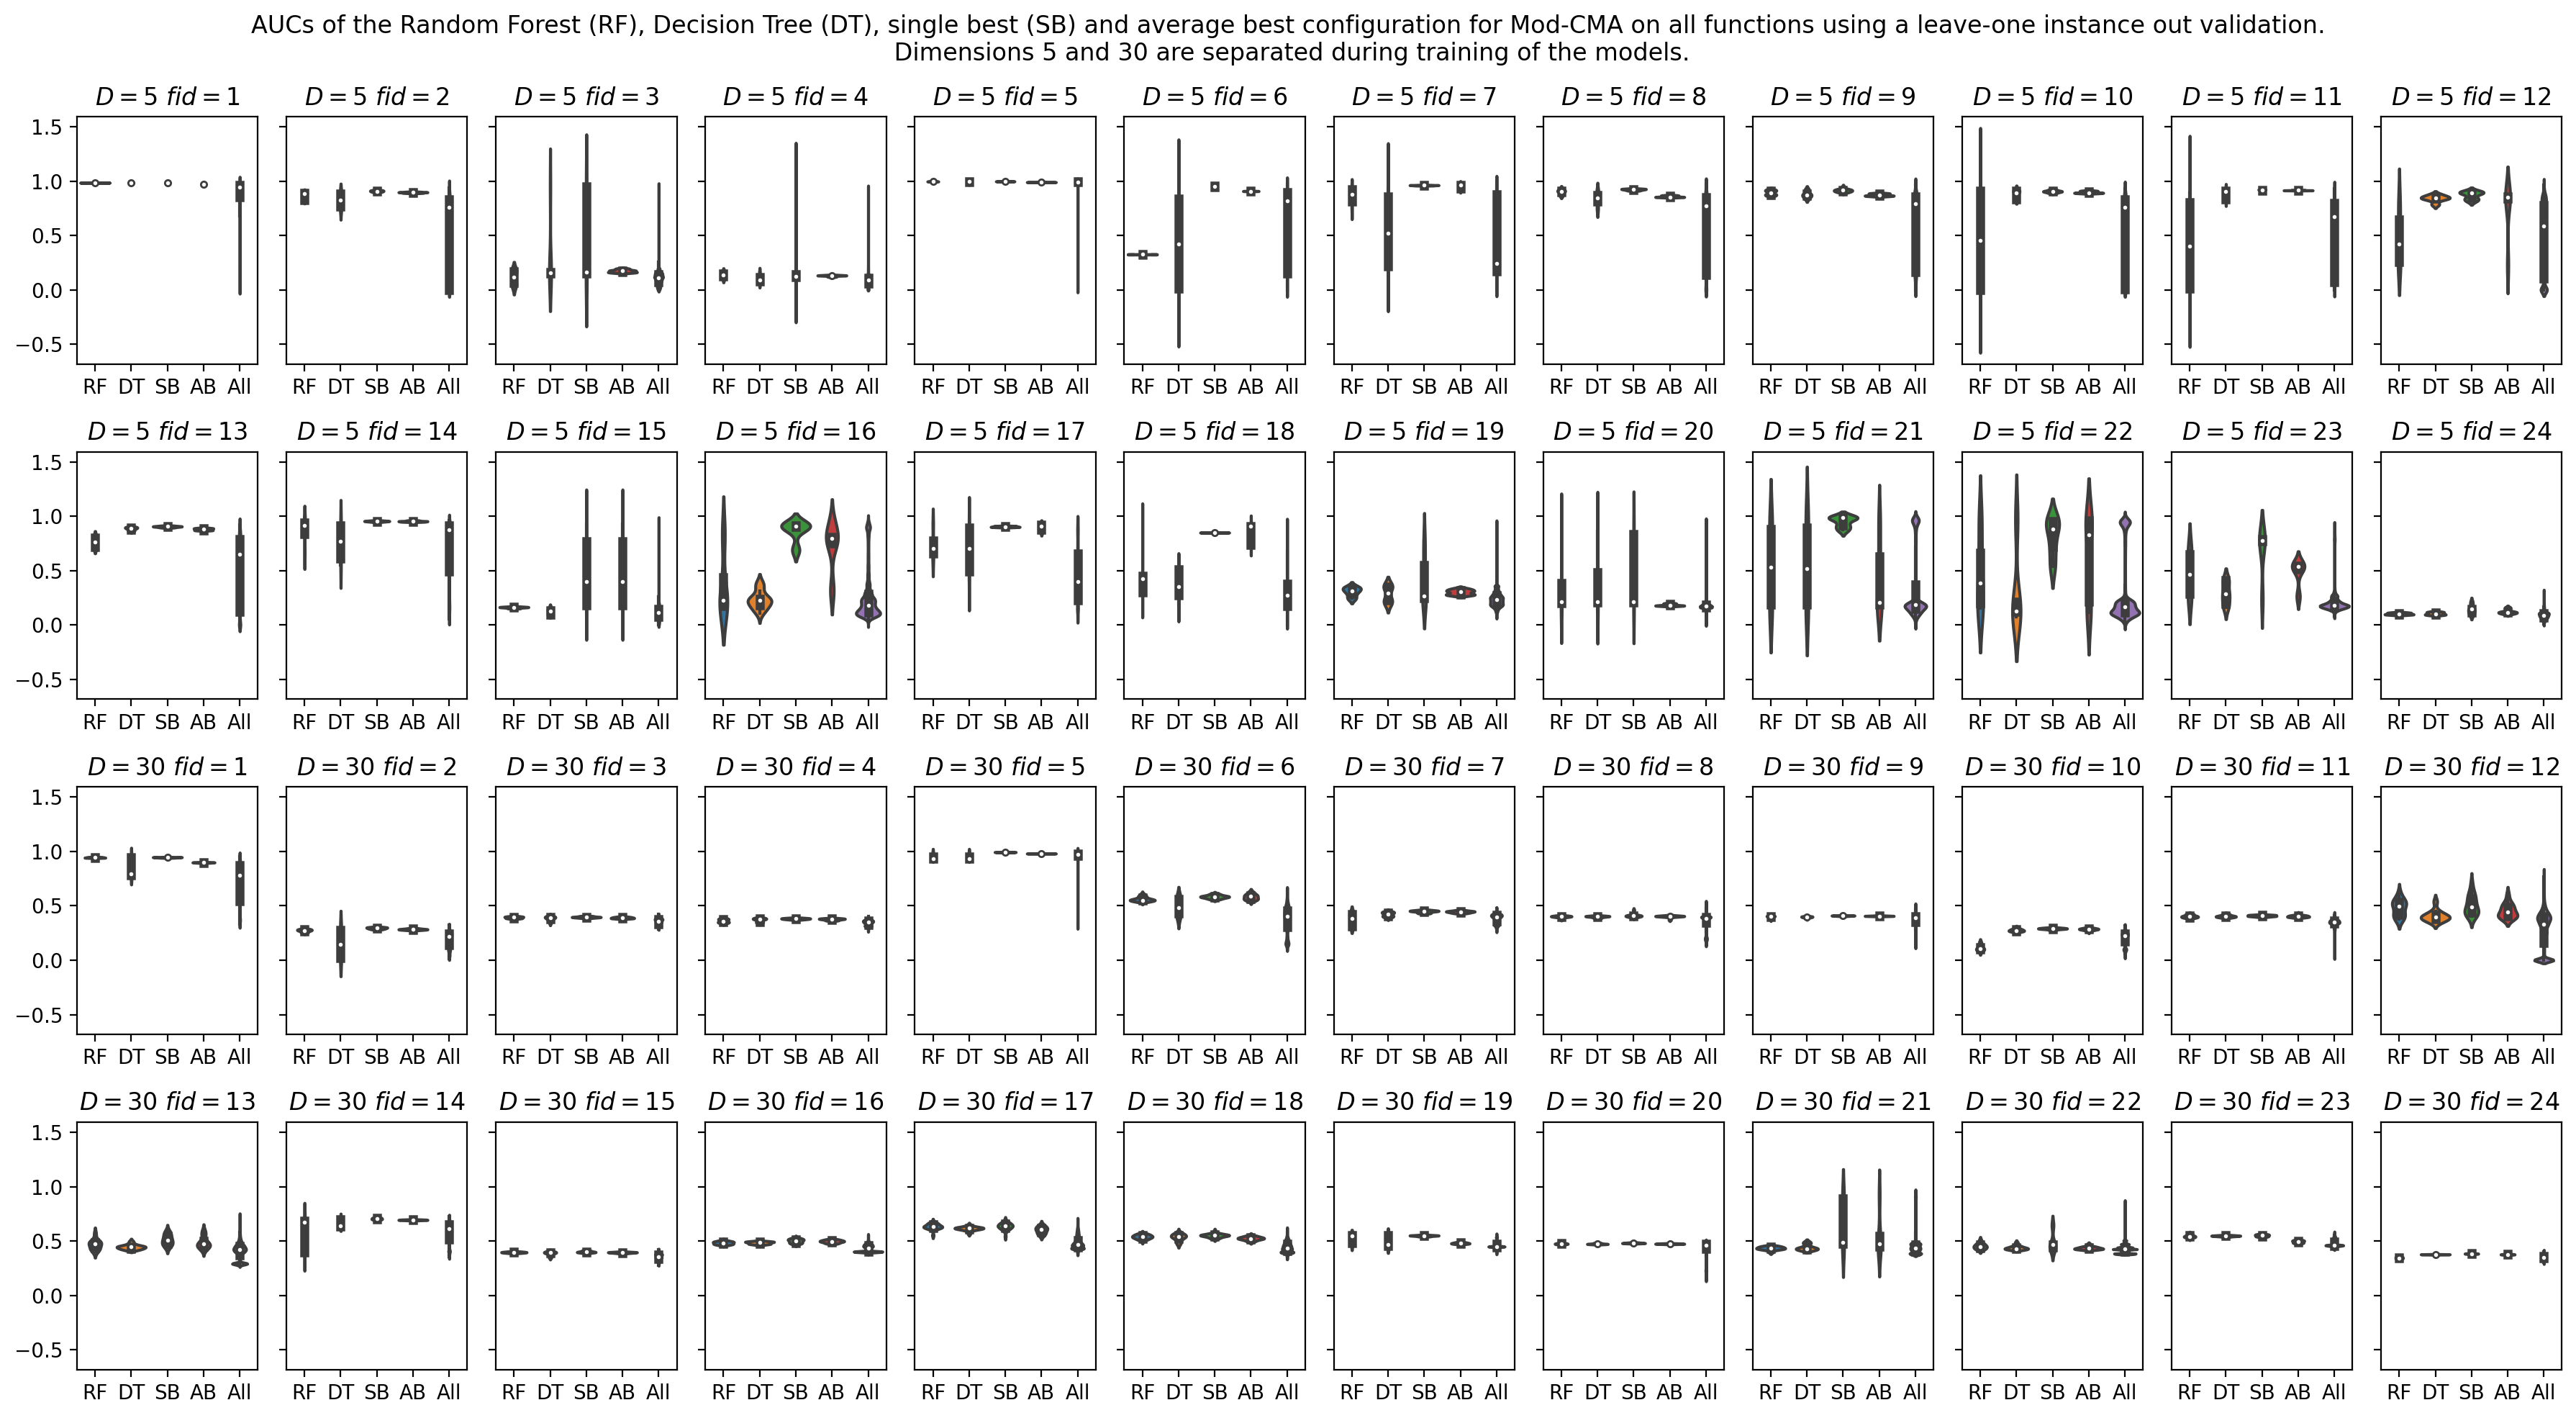

In [25]:
#Leave one instance out
#preprocess the data to train and test
fig, axes = plt.subplots(4, 12, sharey=True, figsize=(18,10))
fig.suptitle('AUCs of the Random Forest (RF), Decision Tree (DT), single best (SB) and average best configuration for Mod-CMA on all functions using a leave-one instance out validation.\n Dimensions 5 and 30 are separated during training of the models.')

dim_counter = 0
for dim in ela_df['dim'].unique():
    _, df_avg_best = cmaes_explainer.get_average_best(dim)
    df = ela_df_cat[ela_df_cat['dim'] == dim].copy()
    
    for fid in ela_df['fid'].unique():
        print(dim, fid)
        box_plot_df = pd.DataFrame(columns=['RF', 'DT','SB','AB', 'All'])

        _, df_single_best = cmaes_explainer.get_single_best(fid, dim)
        box_plot_df['All'] = pd.Series(cmaes_explainer.df[(cmaes_explainer.df['fid'] == fid) & (cmaes_explainer.df['dim'] == dim)]['auc'].values)

        box_plot_df['SB'] = pd.Series(df_single_best['auc'].values)
        box_plot_df['AB'] = pd.Series(df_avg_best[df_avg_best['fid'] == fid]['auc'].values)

        
        all_aucs = []
        all_aucs_rf = []
        for iid in [1,5]:
            X_train = df[df['iid'] != iid].copy().drop(['fid','iid','auc',*features], axis=1)
            y_train = df[df['iid'] != iid][features]
            X_test = df[(df['iid'] == iid) & (df['fid'] == fid)].copy().drop(['fid','iid','auc',*features], axis=1)
            y_test = df[(df['iid'] == iid) & (df['fid'] == fid)][features]

            X_train.replace([np.inf, -np.inf], 0, inplace=True)
            X_test.replace([np.inf, -np.inf], 0, inplace=True)
            X_train.fillna(0, inplace=True)
            X_test.fillna(0, inplace=True)

            dtree = DecisionTreeClassifier(max_depth=7)
            dtree.fit(X_train, y_train)

            #RF
            rf = RandomForestClassifier()
            rf.fit(X_train, y_train)

            #DT
            y_pred = dtree.predict(X_test)

            #RF
            y_red_rf = rf.predict(X_test)

        
            for y in y_pred:
                #print(y)
                conf = predToNames(y, dim)
                #print(conf)
                aucs = cmaes_explainer.get_results_for_config(conf, dim, fid, iid)
                all_aucs.extend(aucs.values)
                #print(all_aucs)
            for y in y_red_rf:
                #print(y)
                conf = predToNames(y, dim)
                #print(conf)
                aucs = cmaes_explainer.get_results_for_config(conf, dim, fid, iid)
                all_aucs_rf.extend(aucs.values)
                #print(all_aucs)

        box_plot_df['DT'] = pd.Series(np.array(all_aucs))
        box_plot_df['RF'] = pd.Series(np.array(all_aucs_rf))
        sns.violinplot(ax=axes[dim_counter + int((fid-1)/12)][(fid-1)%12], data=box_plot_df, showfliers = True, showmeans=True,
                    meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"6"})  
        axes[dim_counter + int((fid-1)/12)][(fid-1)%12].set_title(f"$D={dim}$ $fid={fid}$")
        #axes[dim_counter + int((fid-1)/12)][(fid-1)%12].set_xticklabels(axes[dim_counter + int((fid-1)/12)][(fid-1)%12].get_xticks(), rotation=45)
    dim_counter += 2

plt.tight_layout()
plt.savefig("cma_img_new/classifiers-iid.pdf")
plt.savefig("cma_img_new/classifiers-iid.png")
plt.show()

plt.clf()
plt.close()

In [14]:
%config InlineBackend.figure_format = 'retina' # Make visualizations look good
#%config InlineBackend.figure_format = 'svg' 
%matplotlib inline
    
import logging
logging.getLogger("matplotlib.font_manager").setLevel(logging.ERROR)

#plot decision tree
import dtreeviz

mapping = [[False, True],[False, True], ['mirrored', 'mirrored pairwise'], ['gaussian', 'halton', 'sobol'],['1/2^lambda', 'default', 'equal'], ['BIPOP', 'IPOP'], 
                ['csa', 'psr'], [5.0, 6.0, 8.0, 10.0, 20.0], [2.0, 3.0, 4.0, 5.0, 10.0, 20.0]]

for dim in [5,30]:
    df = ela_df_cat[ela_df_cat['dim'] == dim].copy()

    X_train = df.copy().drop(['fid','iid','auc',*features], axis=1)
    y_train = df[features]

    X_train.replace([np.inf, -np.inf], 0, inplace=True)
    X_train.fillna(0, inplace=True)
    fi = 0
    for f in features:
        
        old_values = y_train[f].unique()
        new_values = np.arange(0,len(y_train[f].unique()))

        y = y_train.copy()
        for n in new_values:
            y.loc[y_train[f] == old_values[n], f] = n #update 4 to 3
        labels = list(np.array(mapping[fi])[old_values])
        #print(old_values, new_values, labels)

        dtree = DecisionTreeClassifier(max_depth=7)
        dtree.fit(X_train, y[f])
        print(f"d{dim} f{f} score", dtree.score(X_train, y[f]))

        viz_model = dtreeviz.model(dtree, X_train, y[f],
            target_name=f,
            feature_names=X_train.columns,
            class_names=labels 
        )
        v = viz_model.view(scale=1.0)
        v.save(f"trees_cma/d{dim}-f{f}.svg")
        fi += 1
    
    #fig = plt.figure(figsize=(25,20))
    #_ = tree.plot_tree(dtree, 
    #                feature_names=X_train.columns,  
    #                class_names=features,
    #                filled=True)
    #plt.show()

d5 fcovariance score 0.9583333333333334


/home/bas/repos/ioh-explainer/env/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


d5 felitist score 1.0


/home/bas/repos/ioh-explainer/env/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


d5 fmirrored score 0.975


/home/bas/repos/ioh-explainer/env/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


d5 fbase_sampler score 0.9583333333333334


/home/bas/repos/ioh-explainer/env/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


d5 fweights_option score 0.925


/home/bas/repos/ioh-explainer/env/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


d5 flocal_restart score 0.975


/home/bas/repos/ioh-explainer/env/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


d5 fstep_size_adaptation score 1.0


/home/bas/repos/ioh-explainer/env/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


d5 flambda_ score 1.0


/home/bas/repos/ioh-explainer/env/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


d5 fmu score 0.9583333333333334


/home/bas/repos/ioh-explainer/env/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


d30 fcovariance score 0.9583333333333334


/home/bas/repos/ioh-explainer/env/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


d30 felitist score 1.0


/home/bas/repos/ioh-explainer/env/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


d30 fmirrored score 0.9666666666666667


/home/bas/repos/ioh-explainer/env/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


d30 fbase_sampler score 0.95


/home/bas/repos/ioh-explainer/env/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


d30 fweights_option score 0.9666666666666667


/home/bas/repos/ioh-explainer/env/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


d30 flocal_restart score 1.0


/home/bas/repos/ioh-explainer/env/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


d30 fstep_size_adaptation score 0.9666666666666667


/home/bas/repos/ioh-explainer/env/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


d30 flambda_ score 0.9416666666666667


/home/bas/repos/ioh-explainer/env/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


d30 fmu score 0.975


/home/bas/repos/ioh-explainer/env/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
